# The Attention Bottleneck

This notebook explores the **attention mechanism** and demonstrates why it becomes a memory bottleneck for long sequences. We'll use a simple GPU simulator to make the memory hierarchy constraints tangible.

**This is Part 1 of 2:**
1. **This notebook**: Understanding the problem — why standard attention doesn't scale
2. **[FlashAttention](./flash_attention.ipynb)**: The solution — online softmax that avoids materializing S and P fully on SRAM

## Prerequisites

You should be familiar with:
- Matrix multiplication
- The transformer architecture (at a high level)
- Basic GPU concepts (the idea that GPUs have fast compute but memory bandwidth is limited)

## 1. The Attention Equation

Given input matrices **Q** (queries), **K** (keys), and **V** (values), attention computes:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right) V$$

Where:
- $Q, K, V \in \mathbb{R}^{N \times d}$ — N is sequence length, d is head dimension
- $QK^T \in \mathbb{R}^{N \times N}$ — the **attention matrix** (this is the problem!)
- $\sqrt{d}$ — scaling factor to keep gradients stable

### The Quadratic Problem

Notice that $QK^T$ produces an $N \times N$ matrix. For a sequence of length 4096:

$$4096 \times 4096 = 16,777,216 \text{ floats}$$

At FP16 (2 bytes/float), that's **32 MB just for one attention matrix**. With multiple heads and layers, this adds up fast.

## 2. Setup: GPU Simulator

We'll use a simple simulator that models the key characteristics of GPU memory hierarchy.

### Quick Terminology

- **HBM (High Bandwidth Memory)**: The GPU's main memory. Large (~80GB) but relatively slow to access.
- **SRAM (On-chip cache)**: Small (~256KB) but very fast. Data here is "free" to access.
- **Working Set**: The data that must be in SRAM *at the same time* to complete a computation. If it exceeds SRAM capacity, the algorithm overflows.
- **The goal**: Minimize HBM traffic by keeping working data in SRAM.

### Our Simulated GPU

We'll use a simulated A100:

### Why the Compute/HBM Ratio Matters

The A100 can do **~150 FLOPs** in the time it takes to load **1 float** from HBM.

This ratio determines whether an operation is **memory-bound** or **compute-bound**:

| If your algorithm does... | Then you're... |
|---------------------------|----------------|
| < 150 FLOPs per float loaded | **Memory-bound** — GPU idles waiting for data |
| > 150 FLOPs per float loaded | **Compute-bound** — memory keeps up |

**Matrix multiply** (C = A @ B with N×N matrices):
- Load: 2N² floats → Compute: 2N³ FLOPs → **Ratio: N FLOPs/float**
- Compute-bound when N > 150 ✓

**Elementwise ops** (scaling, ReLU):
- Load: N floats → Compute: N FLOPs → **Ratio: 1 FLOP/float**  
- Always memory-bound — wastes 149/150 of compute capacity!

**Attention's problem**: Even though matmul is compute-bound, reading/writing the N×N attention matrix forces O(N²) HBM traffic, making the overall operation memory-bound.

In [1]:
from llms_for_dummies.gpu_sim import GPUSpec, Profiler, Tensor
import math

gpu = GPUSpec.sim_a100()
Tensor.verbose = True  # Show step-by-step memory operations

print(f"GPU: {gpu.name}")
print(f"SRAM capacity: {gpu.sram_size:,} floats ({gpu.sram_size * gpu.bytes_per_float / 1024:.0f} KB)")
print(f"Compute/HBM ratio: {gpu.flop_rate / gpu.hbm_bandwidth:.0f}x (compute is faster than memory)")

GPU: Simulated A100
SRAM capacity: 131,072 floats (256 KB)
Compute/HBM ratio: 150x (compute is faster than memory)


## 3. Simple Attention (No Tiling)

Let's implement the full attention computation:
1. **S = Q @ K.T / sqrt(d)** — compute scaled attention scores (N × N)
2. **P = softmax(S)** — normalize scores  
3. **O = P @ V** — apply attention to values

Our Tensor API:
- `Tensor((N, d), "name", prof)` — allocate in HBM
- `tensor.load()` — load full tensor to SRAM
- `tensor.load(rows=(i, j))` — load a slice to SRAM
- `a @ b.T` — matmul (both must be in SRAM)
- `s.scale(factor)` — scale by constant (must be in SRAM)
- `s.softmax()` — softmax (must be in SRAM)
- `result.write_hbm()` — write result to HBM
- `result.free()` — free from SRAM

In [2]:
def attention_no_tiling(prof: Profiler, N: int, d: int):
    """
    Compute Attention(Q, K, V) = softmax(Q @ K.T / sqrt(d)) @ V without tiling.
    
    Loads ALL data into SRAM at once - will overflow for large N!
    """
    # Create tensors in HBM
    Q = Tensor((N, d), "Q", prof)
    K = Tensor((N, d), "K", prof)
    V = Tensor((N, d), "V", prof)
    
    # Load everything to SRAM
    q = Q.load()
    k = K.load()
    v = V.load()
    
    # Step 1: S = Q @ K.T / sqrt(d) (N × N - can overflow!)
    s = (q @ k.T).scale(1.0 / math.sqrt(d), "/√d")
    
    # Step 2: P = softmax(S)
    p = s.softmax()
    s.free()  # Don't need S anymore
    
    # Step 3: O = P @ V
    o = p @ v
    p.free()  # Don't need P anymore
    
    # Write output to HBM
    o.write_hbm()
    
    # Free SRAM
    o.free()
    v.free()
    k.free()
    q.free()

### Small N - Everything Fits

In [3]:
N, d = 128, 64

prof = Profiler(gpu, "Attention - No Tiling (Small N)")
attention_no_tiling(prof, N, d)
prof.report()

[+HBM] Allocate Q (128, 64)                 HBM     16 KB
[+HBM] Allocate K (128, 64)                 HBM     32 KB
[+HBM] Allocate V (128, 64)                 HBM     48 KB
[HBM → SRAM] Load Q                         SRAM │···············│   6%
[HBM → SRAM] Load K                         SRAM │█··············│  12%
[HBM → SRAM] Load V                         SRAM │██·············│  19%
[Compute] Q @ K.T → (128, 128)              SRAM │████···········│  31%
[Compute] scale((Q@K.T)) in-place           SRAM │████···········│  31%
[Compute] softmax((Q@K.T)/√d) → (128, 128)  SRAM │████████·······│  56%
[SRAM] Free (Q@K.T)/√d                      SRAM │████···········│  31%
[Compute] softmax((Q@K.T)/√d) @ V → (128,   SRAM │█████··········│  38%
[SRAM] Free softmax((Q@K.T)/√d)             SRAM │███············│  25%
[SRAM → HBM] Store (softmax((Q@K.T)/√d)@V)  SRAM │███············│  25%
[SRAM] Free (softmax((Q@K.T)/√d)@V)         SRAM │██·············│  19%
[SRAM] Free V                     

### Large N - OVERFLOW!

What happens when N grows? The N×N result matrix explodes:

In [4]:
N, d = 512, 64

prof = Profiler(gpu, "Attention - No Tiling (Large N - OVERFLOW!)")
attention_no_tiling(prof, N, d)
prof.report()

[+HBM] Allocate Q (512, 64)                 HBM     64 KB
[+HBM] Allocate K (512, 64)                 HBM    128 KB
[+HBM] Allocate V (512, 64)                 HBM    192 KB
[HBM → SRAM] Load Q                         SRAM │███············│  25%
[HBM → SRAM] Load K                         SRAM │███████········│  50%
[HBM → SRAM] Load V                         SRAM │███████████····│  75%
[Compute] Q @ K.T → (512, 512)              SRAM │███████████████│ 275% ⚠️ +175%
[Compute] scale((Q@K.T)) in-place           SRAM │███████████████│ 275% ⚠️ +175%
[Compute] softmax((Q@K.T)/√d) → (512, 512)  SRAM │███████████████│ 675% ⚠️ +575%
[SRAM] Free (Q@K.T)/√d                      SRAM │███████████████│ 275% ⚠️ +175%
[Compute] softmax((Q@K.T)/√d) @ V → (512,   SRAM │███████████████│ 300% ⚠️ +200%
[SRAM] Free softmax((Q@K.T)/√d)             SRAM │███████████████│ 100%
[SRAM → HBM] Store (softmax((Q@K.T)/√d)@V)  SRAM │███████████████│ 100%
[SRAM] Free (softmax((Q@K.T)/√d)@V)         SRAM │███████████

**The N×N intermediate matrices don't fit in SRAM!** We need to tile.

## 4. Solution Attempt: 1D Tiling

**Key insight**: Softmax is computed **row-wise**. Each row of P depends only on the corresponding row of S. This means we can process Q in row tiles and compute complete attention for each tile — **without ever writing S to HBM**.

**Strategy**:
1. Load K and V fully into SRAM (they're only N × d each)
2. Process Q in tiles of Br rows at a time
3. For each tile: compute S → softmax → O in SRAM, write only O to HBM

**HBM traffic**: Just Q + K + V + O = **4×N×d = O(N)**. No O(N²) matrix!

**The catch**: K and V must fit in SRAM. As N grows, this becomes impossible.

In [5]:
def attention_1d_tiled(prof: Profiler, N: int, d: int, tile_rows: int):
    """
    Compute Attention(Q, K, V) = softmax(Q @ K.T / sqrt(d)) @ V using 1D tiling.
    
    Strategy: Keep K and V fully in SRAM, tile Q by rows.
    Since softmax is row-wise, we can compute it on row tiles!
    
    HBM traffic: O(N) — only Q, K, V, O touch HBM. S and P stay in SRAM!
    
    Limitation: Requires K + V to fit in SRAM (2 × N × d floats).
    """
    Q = Tensor((N, d), "Q", prof)
    K = Tensor((N, d), "K", prof)
    V = Tensor((N, d), "V", prof)
    
    scale_factor = 1.0 / math.sqrt(d)
    
    # Load ALL of K and V into SRAM (this is why 1D tiling can't scale)
    k = K.load()
    v = V.load()
    
    # Process Q in row tiles
    for i in range(0, N, tile_rows):
        i_end = min(i + tile_rows, N)
        
        # Load tile of Q
        q_tile = Q.load(rows=(i, i_end))
        
        # Step 1: S_tile = Q_tile @ K.T / sqrt(d)  (tile_rows × N)
        s_tile = (q_tile @ k.T).scale(scale_factor, "/√d")
        q_tile.free()
        
        # Step 2: P_tile = softmax(S_tile) — works because we have the full row!
        p_tile = s_tile.softmax()
        s_tile.free()  # S never touches HBM
        
        # Step 3: O_tile = P_tile @ V  (tile_rows × d)
        o_tile = p_tile @ v
        p_tile.free()  # P never touches HBM
        
        # Only O is written to HBM
        o_tile.write_hbm()
        o_tile.free()
    
    v.free()
    k.free()

### 1D Tiling: O(N) Traffic When It Works

For small N, this works great — we get full attention with O(N) HBM traffic:

In [6]:
N, d = 512, 64
tile_rows = gpu.optimal_tile_size_1d(N, d)

print(f"N={N}, d={d}, tile_rows={tile_rows}")
print()

prof = Profiler(gpu, f"1D Tiled Attention (N={N})")
attention_1d_tiled(prof, N, d, tile_rows)
prof.report()

N=512, d=64, tile_rows=40

[+HBM] Allocate Q (512, 64)                 HBM     64 KB
[+HBM] Allocate K (512, 64)                 HBM    128 KB
[+HBM] Allocate V (512, 64)                 HBM    192 KB
[HBM → SRAM] Load K                         SRAM │███············│  25%
[HBM → SRAM] Load V                         SRAM │███████········│  50%
[HBM → SRAM] Load Q[0:40]                   SRAM │███████········│  52%
[Compute] Q[0:40] @ K.T → (40, 512)         SRAM │██████████·····│  68%
[Compute] scale((Q[0:40]@K.T)) in-place     SRAM │██████████·····│  68%
[SRAM] Free Q[0:40]                         SRAM │█████████······│  66%
[Compute] softmax((Q[0:40]@K.T)/√d) → (40,  SRAM │██████████████·│  97%
[SRAM] Free (Q[0:40]@K.T)/√d                SRAM │█████████······│  66%
[Compute] softmax((Q[0:40]@K.T)/√d) @ V →   SRAM │██████████·····│  68%
[SRAM] Free softmax((Q[0:40]@K.T)/√d)       SRAM │███████········│  52%
[SRAM → HBM] Store (softmax((Q[0:40]@K.T)/  SRAM │███████········│  52%
[SRAM] 

### 1D Tiling Breaks Down for Large N

The problem is not HBM traffic — 1D tiling has optimal O(N) traffic. The problem is **SRAM capacity**:
- K and V must stay in SRAM: 2 × N × d floats
- As N grows, K + V alone fill SRAM

Eventually, 1D tiling becomes impossible:

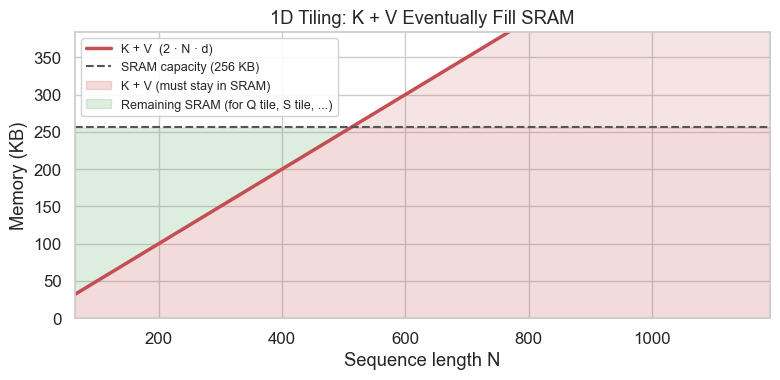

In [7]:
from llms_for_dummies.plots import plot_1d_tiling_sram_limit

plot_1d_tiling_sram_limit(gpu, d=128)

**The fix**: Tile in **both** dimensions so we don't need K fully in SRAM.

## 5. 2D Tiling: Scales to Any N, But Loses O(N) Traffic

**Idea**: Don't keep K fully in SRAM. Tile both Q and K.

For `S = Q @ K.T`:
- Q tile: Br × d
- K tile: Bc × d  
- S tile: Br × Bc (independent of N!)

**Working set**: Br×d + Bc×d + Br×Bc — all terms controlled by tile sizes, not N. ✓

**But here's the problem**: We can only compute a Br × Bc tile of S at a time. Softmax needs a **full row** of S (all N columns). We can't compute softmax until we have all the S tiles for that row.

**The naive solution**: Write each S tile to HBM. After computing all tiles, read S back row by row for softmax.

This means we're **back to O(N²) HBM traffic** — we must write/read the full N×N matrix S.

| Strategy | Scales to Large N? | HBM Traffic |
|----------|-------------------|-------------|
| No tiling | No (SRAM overflow) | O(N) when it fits |
| 1D tiling | No (K+V must fit) | **O(N)** ✓ |
| 2D tiling (naive) | Yes ✓ | O(N²) |

We've traded one problem for another!

In [8]:
def attention_2d_tiled(prof: Profiler, N: int, d: int, tile_size: int):
    """
    Compute full Attention(Q, K, V) using naive 2D tiling.
    
    Strategy: Tile both Q and K so each S tile is tile_size × tile_size (independent of N).
    
    HBM traffic: O(N²) — we must write S to HBM, read it back for softmax,
    write P to HBM, and read it back for P @ V.
    
    This is the naive approach. FlashAttention solves this with online softmax.
    """
    Q = Tensor((N, d), "Q", prof)
    K = Tensor((N, d), "K", prof)
    V = Tensor((N, d), "V", prof)
    
    scale_factor = 1.0 / math.sqrt(d)
    sram_size = prof.spec.sram_size
    
    # ==========================================================================
    # Step 1: Compute S = Q @ K.T / sqrt(d) using 2D tiling
    # 
    # Working set: Q tile + K tile + S tile = tile_size×d + tile_size×d + tile_size²
    # All tiles are small, independent of N. ✓
    # 
    # But we must write S to HBM — can't do softmax until we have full rows.
    # ==========================================================================
    S = Tensor((N, N), "S", prof)  # Allocate full N×N in HBM!
    
    for i in range(0, N, tile_size):
        i_end = min(i + tile_size, N)
        q_tile = Q.load(rows=(i, i_end))
        
        for j in range(0, N, tile_size):
            j_end = min(j + tile_size, N)
            k_tile = K.load(rows=(j, j_end))
            
            # Compute S[i:i_end, j:j_end]
            s_tile = (q_tile @ k_tile.T).scale(scale_factor, "/√d")
            s_tile.write_hbm()  # Must write — can't do softmax yet
            s_tile.free()
            k_tile.free()
        
        q_tile.free()
    
    # ==========================================================================
    # Step 2: P = softmax(S)
    # 
    # Problem: Softmax needs FULL ROWS of S (all N columns) to normalize.
    # We can't use the same tile size as step 1!
    # 
    # Working set per row block:
    #   - S rows (input):  softmax_rows × N
    #   - P rows (output): softmax_rows × N  
    #   - Scratch (exp):   softmax_rows × N
    #   Total: 3 × softmax_rows × N ≤ SRAM
    # 
    # So: softmax_rows = SRAM / (3 × N)
    # 
    # For large N, this becomes tiny! Another inefficiency of naive 2D tiling.
    # FlashAttention avoids this with online softmax (never needs full rows).
    # ==========================================================================
    P = Tensor((N, N), "P", prof)  # Another N×N matrix in HBM!
    
    softmax_rows = sram_size // (3 * N)
    softmax_rows = max(1, softmax_rows)  # At least 1 row
    
    for i in range(0, N, softmax_rows):
        i_end = min(i + softmax_rows, N)
        
        # Load softmax_rows full rows of S (each row is N floats)
        s_rows = S.load(rows=(i, i_end))
        
        # Now we can compute softmax (we have full rows)
        p_rows = s_rows.softmax()
        s_rows.free()
        
        # Write P rows back to HBM
        p_rows.write_hbm()
        p_rows.free()
    
    S.free_hbm()  # Done with S
    
    # ==========================================================================
    # Step 3: O = P @ V using tiling with accumulation
    # 
    # Working set: P tile + V tile + partial + accum
    #            = tile_size² + tile_size×d + tile_size×d + tile_size×d
    # All tiles are small, independent of N. ✓
    # ==========================================================================
    for i in range(0, N, tile_size):
        i_end = min(i + tile_size, N)
        actual_rows = i_end - i
        
        # Accumulator for this row block of O
        o_accum = Tensor.zeros((actual_rows, d), f"O[{i}:{i_end}]", prof)
        
        for j in range(0, N, tile_size):
            j_end = min(j + tile_size, N)
            
            # Load tiles
            p_tile = P.load(rows=(i, i_end), cols=(j, j_end))
            v_tile = V.load(rows=(j, j_end))
            
            # Compute partial result: (tile × tile) @ (tile × d) = tile × d
            partial = p_tile @ v_tile
            p_tile.free()
            v_tile.free()
            
            # Accumulate: O[i:i_end] += partial
            o_accum.add_(partial)
            partial.free()
        
        # Write accumulated O tile to HBM
        o_accum.write_hbm()
        o_accum.free()
    
    P.free_hbm()  # Done with P

In [9]:
N, d = 1024, 64
tile_size = gpu.optimal_tile_size_2d(d)
softmax_rows = gpu.sram_size // (3 * N)

print(f"N={N}, d={d}")
print(f"Tile size: {tile_size} × {tile_size} (for S computation and O accumulation)")
print(f"Softmax rows: {softmax_rows} (smaller — must load full rows of width N)")
print()

Tensor.verbose = False  # Too many iterations
prof = Profiler(gpu, f"2D Tiled Attention (N={N})")
attention_2d_tiled(prof, N, d, tile_size)
prof.report()
Tensor.verbose = True

# Show the O(N²) vs O(N) comparison
print(f"\n--- HBM Traffic Breakdown ---")
print(f"Input (Q, K, V):       {3*N*d:>12,} floats  O(N×d)")
print(f"Output (O):            {N*d:>12,} floats  O(N×d)")
print(f"Intermediate (S + P):  {2*N*N:>12,} floats  O(N²) ← the problem!")
print()
print(f"Intermediate is {2*N*N / (3*N*d):.0f}× larger than input!")

N=1024, d=64
Tile size: 278 × 278 (for S computation and O accumulation)
Softmax rows: 42 (smaller — must load full rows of width N)

2D Tiled Attention (N=1024)

Memory Usage:
  Peak HBM:     4.4 MB
  Peak SRAM:  │██████████████·│ 100%

HBM Traffic:
  Reads:        2,686,976 floats (5.1 MB)
  Writes:       2,162,688 floats (4.1 MB)
  Total:        4,849,664 floats (9.2 MB)

Time Breakdown:
  ┌──────────────────────────────────────────────────┐
  │██████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░│
  └──────────────────────────────────────────────────┘
   Computing (28%)                  Waiting for HBM (72%)

→ Memory-bound (GPU is waiting on HBM)

--- HBM Traffic Breakdown ---
Input (Q, K, V):            196,608 floats  O(N×d)
Output (O):                  65,536 floats  O(N×d)
Intermediate (S + P):     2,097,152 floats  O(N²) ← the problem!

Intermediate is 11× larger than input!


## 6. Summary: The Tradeoff

| Strategy | Scales to Large N? | HBM Traffic |
|----------|-------------------|-------------|
| No tiling | No — SRAM overflow | O(N) when it fits |
| 1D tiling | No — K+V must fit | **O(N)** ✓ |
| 2D tiling (naive) | **Yes** ✓ | O(N²) |

**The dilemma**: 
- 1D tiling gives O(N) traffic but doesn't scale
- 2D tiling scales but has O(N²) traffic

Can we get the best of both? **Yes — that's FlashAttention.**

## 7. What's Next?

2D tiling's O(N²) traffic comes entirely from materializing S and P — the N×N intermediates that must pass through HBM because softmax needs full rows.

Can we avoid writing S and P to HBM entirely? Can we compute softmax *without* needing full rows?

The key insight of FlashAttention is **online softmax** — maintaining running statistics (max and sum) that let us compute softmax *incrementally*, correcting partial results as we see more data. This lets us use 2D tiling without ever materializing S or P.

**Continue to [flash_attention.ipynb](./flash_attention.ipynb) to see how!**